In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
data = pd.read_csv(r"C:\Users\Srushti\Downloads\tweets.csv")   
print("Dataset loaded successfully!")
print(data.head())

Dataset loaded successfully!
       tweet_id airline_sentiment  airline_sentiment_confidence  \
0  5.700000e+17           neutral                        1.0000   
1  5.700000e+17          positive                        0.3486   
2  5.700000e+17           neutral                        0.6837   
3  5.700000e+17          negative                        1.0000   
4  5.700000e+17          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN            0.0   
1                    NaN    jnardino   

In [3]:
data = data[['text', 'airline_sentiment']]
print("\nDataset shape:", data.shape)
# print(data['airline_sentiment'].value_counts())



Dataset shape: (14641, 2)


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['airline_sentiment'])  # numeric labels

In [5]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Common slang replacements for tweets
slang_dict = {
    "u": "you", "r": "are", "ur": "your", "gr8": "great", "btw": "by the way",
    "idk": "i don't know", "luv": "love", "omg": "oh my god", "lol": "laughing",
    "thx": "thanks", "pls": "please", "smh": "shaking my head", "w/": "with",
    "b4": "before", "lmao": "laughing", "omw": "on my way",


    "aa": "american airlines",
    "ua": "united airlines",
    "usairways": "us airways",
    "jetblue": "jet blue",
    "sw": "southwest",
    "swa": "southwest airlines",
    "flt": "flight",
    "svc": "service",
    "cust": "customer",
    "bagg": "baggage",
    "dep": "departure",
    "arr": "arrival",
    "gateagent": "gate agent",
    "tsa": "transportation security administration",
}

def clean_text(text):
    text = str(text).lower()

    text = re.sub(r"http\S+|www\S+", "", text)
    
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
 
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    words = text.split()
    words = [slang_dict.get(w, w) for w in words]
    

    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 1]
    

    cleaned_text = " ".join(words)
    
    return cleaned_text


In [6]:
data['cleaned'] = data['text'].apply(clean_text)

In [7]:

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['cleaned'])

X = tokenizer.texts_to_sequences(data['cleaned'])
X = pad_sequences(X, maxlen=40)
y = data['label'].values

print("\nVocabulary size:", len(tokenizer.word_index))
print("Padded sequence shape:", X.shape)
vocab_size=len(tokenizer.word_index)


Vocabulary size: 12465
Padded sequence shape: (14641, 40)


In [8]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (11712, 40)
Testing data shape: (2929, 40)


In [9]:
# model = Sequential()
# model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(3, activation='softmax'))  

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

models={}
# --- ANN ---
ann = Sequential([
    Embedding(10000, 128, input_length=40),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
models["ANN"] = ann

# --- CNN ---
cnn = Sequential([
    Embedding(10000, 128, input_length=40),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
models["CNN"] = cnn

# --- LSTM ---
lstm = Sequential([
    Embedding(10000, 128, input_length=40),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
models["LSTM"] = lstm

# --- BiLSTM ---
bilstm = Sequential([
    Embedding(10000, 128, input_length=40),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(3, activation='softmax')
])
bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
models["BiLSTM"] = bilstm


In [10]:
results = []
for name, model in models.items():
    print(f"\n🚀 Training {name} model...")
    history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2, verbose=1)

    y_pred = np.argmax(model.predict(X_test), axis=-1)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    results.append({"Model": name, "Accuracy": acc})


🚀 Training ANN model...
Epoch 1/3
147/147 [==============================] - 5s 29ms/step - loss: 0.7851 - accuracy: 0.6489 - val_loss: 0.6735 - val_accuracy: 0.7034
Epoch 2/3
147/147 [==============================] - 4s 30ms/step - loss: 0.5312 - accuracy: 0.7791 - val_loss: 0.5662 - val_accuracy: 0.7764
Epoch 3/3
92/92 [==============================] - 0s 2ms/step

✅ ANN Accuracy: 0.7627
              precision    recall  f1-score   support

    negative       0.82      0.89      0.85      1836
     neutral       0.59      0.51      0.55       620
    positive       0.70      0.60      0.65       473

    accuracy                           0.76      2929
   macro avg       0.71      0.67      0.68      2929
weighted avg       0.75      0.76      0.76      2929


🚀 Training CNN model...
Epoch 1/3
147/147 [==============================] - 7s 38ms/step - loss: 0.7522 - accuracy: 0.6719 - val_loss: 0.6129 - val_accuracy: 0.7503
Epoch 2/3
147/147 [==============================] - 5s 

In [11]:
y_pred_lstm = np.argmax(lstm.predict(X_test), axis=-1)
y_pred_cnn = np.argmax(cnn.predict(X_test), axis=-1)
y_pred_bilstm = np.argmax(bilstm.predict(X_test), axis=-1)
y_pred_ann=np.argmax(ann.predict(X_test),axis=-1)

92/92 [==============================] - 0s 2ms/step


In [12]:
def evaluate_model(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ {model_name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(5,4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title(f"{model_name} Confusion Matrix")
    # plt.xlabel("Predicted")
    # plt.ylabel("Actual")
    # plt.show()

In [13]:
evaluate_model(y_test, y_pred_lstm, "LSTM")
evaluate_model(y_test, y_pred_cnn, "CNN")
evaluate_model(y_test, y_pred_bilstm, "BiLSTM")
evaluate_model(y_test,y_pred_ann,"ANN")


✅ LSTM Accuracy: 0.7791
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1836
           1       0.61      0.58      0.60       620
           2       0.71      0.67      0.69       473

    accuracy                           0.78      2929
   macro avg       0.72      0.71      0.72      2929
weighted avg       0.78      0.78      0.78      2929


✅ CNN Accuracy: 0.7569
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1836
           1       0.53      0.61      0.57       620
           2       0.78      0.56      0.65       473

    accuracy                           0.76      2929
   macro avg       0.72      0.68      0.69      2929
weighted avg       0.76      0.76      0.76      2929


✅ BiLSTM Accuracy: 0.7740
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1836
           1       0.59      0.61      0.60       620

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example sentence(s) to predict
examples = [
    "The flight was amazing, I loved the service!",
    "Worst experience ever, I will never fly again.",
    "It was okay, nothing special about the flight."
]

# Convert text to sequences and pad
sequences = tokenizer.texts_to_sequences(examples)
X_examples = pad_sequences(sequences, maxlen=X_train.shape[1])  # same length as training data


In [15]:
y_pred_lstm = lstm.predict(X_examples)
if y_pred_lstm.shape[1] > 1:  # multi-class
    y_pred_lstm = np.argmax(y_pred_lstm, axis=-1)
else:  # binary
    y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

1/1 [==============================] - 0s 60ms/step


In [16]:
y_pred_cnn = cnn.predict(X_examples)
if y_pred_cnn.shape[1] > 1:
    y_pred_cnn = np.argmax(y_pred_cnn, axis=-1)
else:
    y_pred_cnn = (y_pred_cnn > 0.5).astype(int)


1/1 [==============================] - 0s 73ms/step


In [17]:
y_pred_bilstm = bilstm.predict(X_examples)
if y_pred_bilstm.shape[1] > 1:
    y_pred_bilstm = np.argmax(y_pred_bilstm, axis=-1)
else:
    y_pred_bilstm = (y_pred_bilstm > 0.5).astype(int)


1/1 [==============================] - 0s 64ms/step


In [18]:
y_pred_ann = ann.predict(X_examples)
if y_pred_ann.shape[1] > 1:
    y_pred_ann = np.argmax(y_pred_ann, axis=-1)
else:
    y_pred_ann = (y_pred_ann > 0.5).astype(int)

1/1 [==============================] - 0s 43ms/step


In [19]:
# If using LabelEncoder
pred_labels_lstm = le.inverse_transform(y_pred_lstm)
pred_labels_cnn = le.inverse_transform(y_pred_cnn)
pred_labels_bilstm = le.inverse_transform(y_pred_bilstm)
pred_labels_ann = le.inverse_transform(y_pred_ann)

for i, text in enumerate(examples):
    print(f"\nText: {text}")
    print(f"LSTM Prediction: {pred_labels_lstm[i]}")
    print(f"CNN Prediction: {pred_labels_cnn[i]}")
    print(f"BiLSTM Prediction: {pred_labels_bilstm[i]}")
    print(f"ANN Prediction: {pred_labels_ann[i]}")



Text: The flight was amazing, I loved the service!
LSTM Prediction: positive
CNN Prediction: positive
BiLSTM Prediction: positive
ANN Prediction: positive

Text: Worst experience ever, I will never fly again.
LSTM Prediction: negative
CNN Prediction: negative
BiLSTM Prediction: negative
ANN Prediction: negative

Text: It was okay, nothing special about the flight.
LSTM Prediction: negative
CNN Prediction: negative
BiLSTM Prediction: negative
ANN Prediction: negative


In [20]:
#ENSEMBLE TECHNIQUE
y_probs = (lstm.predict(X_test) + cnn.predict(X_test) + bilstm.predict(X_test) + ann.predict(X_test))/ 4
y_ensemble = np.argmax(y_probs, axis=-1)
acc = accuracy_score(y_test, y_ensemble)
print(f"Ensemble Accuracy: {acc:.4f}")

92/92 [==============================] - 0s 1ms/step
Ensemble Accuracy: 0.7774


In [21]:
#HYPERPARAMETER TUNING
maxlen=40
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=hp.Choice('embedding_dim', [50,100,200]),
                        input_length=maxlen))
    
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', 64, 256, step=64),
                                 dropout=hp.Float('dropout', 0.2, 0.5, step=0.1))))
    
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='sentiment_analysis'
)

tuner.search(X_train, y_train, epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(1)[0]

best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

tuner.results_summary()


C:\Users\Srushti\AppData\Local\Temp\ipykernel_10228\2277181725.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from tuner_results\sentiment_analysis\tuner0.json
{'embedding_dim': 200, 'lstm_units': 192, 'dropout': 0.4}
Results summary
Results in tuner_results\sentiment_analysis
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
embedding_dim: 200
lstm_units: 192
dropout: 0.4
Score: 0.7904396057128906

Trial 07 summary
Hyperparameters:
embedding_dim: 100
lstm_units: 128
dropout: 0.4
Score: 0.7883055806159973

Trial 05 summary
Hyperparameters:
embedding_dim: 50
lstm_units: 192
dropout: 0.2
Score: 0.7878788113594055

Trial 06 summary
Hyperparameters:
embedding_dim: 50
lstm_units: 128
dropout: 0.30000000000000004
Score: 0.7848911881446838

Trial 09 summary
Hyperparameters:
embedding_dim: 100
lstm_units: 128
dropout: 0.2
Score: 0.7844643592834473

Trial 01 summary
Hyperparameters:
embedding_dim: 50
lstm_units: 64
dropout: 0.4
Score: 0.7836107611656189

Trial 02 summary
Hyperparameters:
embedding_dim: 100
lstm_units: 128
dropout: 

In [15]:
# ==========================================================
# STEP 10: Train the Model
# ==========================================================
# history = model.fit(
#     X_train, y_train,
#     epochs=5,
#     batch_size=64,
#     validation_split=0.2,
#     verbose=1
# )

Epoch 1/5
147/147 [==============================] - 22s 135ms/step - loss: 0.7519 - accuracy: 0.6880 - val_loss: 0.5895 - val_accuracy: 0.7657
Epoch 2/5
147/147 [==============================] - 20s 136ms/step - loss: 0.4780 - accuracy: 0.8131 - val_loss: 0.5595 - val_accuracy: 0.7793
Epoch 3/5
147/147 [==============================] - 22s 147ms/step - loss: 0.3342 - accuracy: 0.8785 - val_loss: 0.6050 - val_accuracy: 0.7704
Epoch 4/5
147/147 [==============================] - 21s 143ms/step - loss: 0.2457 - accuracy: 0.9141 - val_loss: 0.6866 - val_accuracy: 0.7687
Epoch 5/5
147/147 [==============================] - 25s 173ms/step - loss: 0.1945 - accuracy: 0.9316 - val_loss: 0.7315 - val_accuracy: 0.7717


In [22]:
model.save("aids_latest_mpr.h5")

In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.2f}")

92/92 [==============================] - 1s 13ms/step - loss: 0.6167 - accuracy: 0.7740

Test Accuracy: 0.77


In [24]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([clean_text(text)])
    padded = pad_sequences(seq, maxlen=50)
    pred = model.predict(padded)
    labels = ['Negative', 'Neutral', 'Positive']
    return labels[np.argmax(pred)]

# Try a few examples
examples = [
    "The flight was delayed and staff were rude!",
    "Amazing service and smooth flight!",
    "The flight was okay, nothing special."
]

for e in examples:
    print(f"Tweet: {e}")
    print(f"Predicted Sentiment: {predict_sentiment(e)}\n")

Tweet: The flight was delayed and staff were rude!
1/1 [==============================] - 0s 494ms/step
Predicted Sentiment: Negative

Tweet: Amazing service and smooth flight!
1/1 [==============================] - 0s 25ms/step
Predicted Sentiment: Positive

Tweet: The flight was okay, nothing special.
1/1 [==============================] - 0s 23ms/step
Predicted Sentiment: Negative



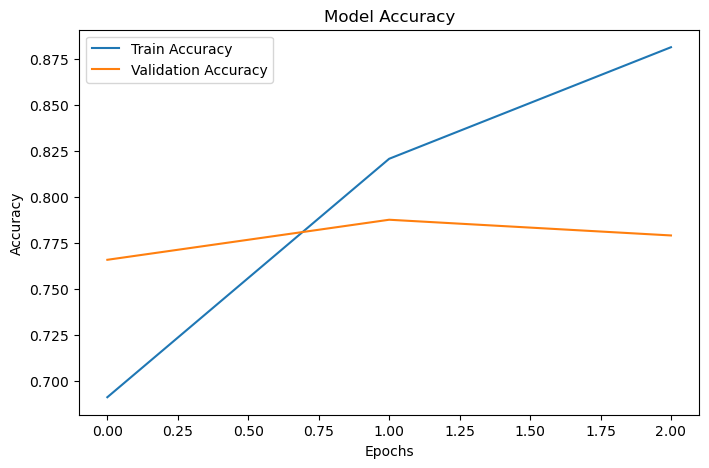

In [25]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()